
# Scalable Growth Infrastructure & Automation (Portfolio Project)
**Goal:** Demonstrate an end-to-end analytics workflow that integrates multiple data sources, applies data quality checks, builds KPI-ready datasets, and exports clean tables for BI dashboards (Power BI / Excel).

**Tech:** Python (Pandas), SQL-ready outputs, BI-ready CSV exports  
**Data:** Synthetic dataset (safe for GitHub)



## Setup & Folder Structure

```
project-root/
    customer_data.csv
    sales_data.csv
    performance_metrics_daily.csv
    sales_leaderboard_monthly.csv
    data_quality_issues_sample.csv
    growth_pipeline.ipynb   (this notebook)
```



In [14]:

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DATA_DIR = Path(".")
OUT_DIR = Path("outputs")
OUT_DIR.mkdir(exist_ok=True)

print("DATA_DIR:", DATA_DIR.resolve())
print("OUT_DIR:", OUT_DIR.resolve())


DATA_DIR: C:\Users\aksha\anaconda_projects\ab60ec39-e4ea-4235-8588-09d755baa350
OUT_DIR: C:\Users\aksha\anaconda_projects\ab60ec39-e4ea-4235-8588-09d755baa350\outputs


## 1) Load Data

In [15]:

customers = pd.read_csv(DATA_DIR / "customer_data.csv")
sales = pd.read_csv(DATA_DIR / "sales_data.csv")
daily_kpis = pd.read_csv(DATA_DIR / "performance_metrics_daily.csv")
leaderboard = pd.read_csv(DATA_DIR / "sales_leaderboard_monthly.csv")
dq_issues = pd.read_csv(DATA_DIR / "data_quality_issues_sample.csv")

display(customers.head())
display(sales.head())
print("customers:", customers.shape)
print("sales:", sales.shape)
print("daily_kpis:", daily_kpis.shape)
print("leaderboard:", leaderboard.shape)
print("dq_issues:", dq_issues.shape)


,customer_id,signup_date,region,industry,risk_score
0,100000,2024-03-06,Northeast,Restaurant,59.8
1,100001,2025-07-19,Midwest,Construction,52.0
2,100002,2025-04-23,Northeast,Services,31.0
3,100003,2024-11-16,Midwest,Restaurant,56.1
4,100004,2024-11-12,South,Other,36.8


,transaction_id,date,customer_id,channel,product_tier,revenue,approved,processing_failure,disputed
0,T000000001,2024-01-01,101284,Web,Growth,244.92,0,0,0
1,T000000002,2024-01-01,100460,Outbound,Starter,168.54,1,0,0
2,T000000003,2024-01-01,100754,Outbound,Starter,152.65,1,0,0
3,T000000004,2024-01-01,100912,Web,Starter,173.98,0,0,0
4,T000000005,2024-01-01,101109,Web,Growth,345.86,1,0,0


customers: (1500, 5)
sales: (65687, 9)
daily_kpis: (731, 9)
leaderboard: (720, 6)
dq_issues: (60, 5)


## 2) Quick Profiling

In [16]:

def profile_df(df, name):
    print(f"\n=== {name} ===")
    print(df.dtypes)
    print("Missing values (top 10):")
    display(df.isna().sum().sort_values(ascending=False).head(10))
    print("Duplicate rows:", df.duplicated().sum())

profile_df(customers, "customers")
profile_df(sales, "sales")
profile_df(daily_kpis, "daily_kpis")
profile_df(leaderboard, "leaderboard")



=== customers ===
customer_id      int64
signup_date     object
region          object
industry        object
risk_score     float64
dtype: object
Missing values (top 10):


customer_id    0
signup_date    0
region         0
industry       0
risk_score     0
dtype: int64

Duplicate rows: 0

=== sales ===
transaction_id         object
date                   object
customer_id             int64
channel                object
product_tier           object
revenue               float64
approved                int64
processing_failure      int64
disputed                int64
dtype: object
Missing values (top 10):


transaction_id        0
date                  0
customer_id           0
channel               0
product_tier          0
revenue               0
approved              0
processing_failure    0
disputed              0
dtype: int64

Duplicate rows: 0

=== daily_kpis ===
date                        object
total_transactions           int64
total_revenue              float64
approval_rate              float64
processing_failure_rate    float64
dispute_rate               float64
revenue_7d_ma              float64
approval_7d_ma             float64
month                       object
dtype: object
Missing values (top 10):


approval_7d_ma             6
revenue_7d_ma              6
date                       0
total_transactions         0
total_revenue              0
processing_failure_rate    0
approval_rate              0
dispute_rate               0
month                      0
dtype: int64

Duplicate rows: 0

=== leaderboard ===
month                        object
salesperson_id               object
closed_deals                  int64
funded_amount               float64
spif_amount                   int64
presidents_club_eligible      int64
dtype: object
Missing values (top 10):


month                       0
salesperson_id              0
closed_deals                0
funded_amount               0
spif_amount                 0
presidents_club_eligible    0
dtype: int64

Duplicate rows: 0



## 3) Data Quality Checks (QA/QC)
 
 running common checks:
- Missing values
- Duplicates
- Join integrity (sales must map to a customer)
- Outlier review (revenue)

We do not delete suspicious rows silently — we **flag** and **document**.


In [17]:

# 3.1 Type fixes
sales["date"] = pd.to_datetime(sales["date"], errors="coerce")
customers["signup_date"] = pd.to_datetime(customers["signup_date"], errors="coerce")

# 3.2 Join integrity
missing_customers = sales.loc[~sales["customer_id"].isin(customers["customer_id"])]
print("Sales rows with missing customer_id match:", len(missing_customers))

# 3.3 Duplicate transactions
dup_tx = sales[sales.duplicated(subset=["transaction_id"], keep=False)]
print("Duplicate transaction_id rows:", len(dup_tx))

# 3.4 Revenue outliers (simple IQR rule)
q1 = sales["revenue"].quantile(0.25)
q3 = sales["revenue"].quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

outliers = sales[(sales["revenue"] < lower) | (sales["revenue"] > upper)]
print("Revenue outliers flagged (IQR):", len(outliers))

# Save QC findings
qc_summary = pd.DataFrame({
    "check": ["missing_customer_match", "duplicate_transaction_id", "revenue_outliers_iqr"],
    "flagged_rows": [len(missing_customers), len(dup_tx), len(outliers)]
})
qc_summary.to_csv(OUT_DIR / "qc_summary.csv", index=False)
qc_summary


Sales rows with missing customer_id match: 0
Duplicate transaction_id rows: 0
Revenue outliers flagged (IQR): 2542


,check,flagged_rows
0,missing_customer_match,0
1,duplicate_transaction_id,0
2,revenue_outliers_iqr,2542


## 4) System Integration: Build a Unified Dataset

In [18]:

# Merge sales + customer master data
df = sales.merge(customers, on="customer_id", how="left")

# Basic cleaning / standardization
df["revenue"] = pd.to_numeric(df["revenue"], errors="coerce")
df["approved"] = df["approved"].astype(int)
df["processing_failure"] = df["processing_failure"].astype(int)
df["disputed"] = df["disputed"].astype(int)

# Add time features
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.to_period("M").astype(str)
df["day_of_week"] = df["date"].dt.day_name()

display(df.head())
print("Unified dataset shape:", df.shape)

df.to_csv(OUT_DIR / "unified_sales_customer.csv", index=False)


,transaction_id,date,customer_id,channel,product_tier,revenue,approved,processing_failure,disputed,signup_date,region,industry,risk_score,year,month,day_of_week
0,T000000001,2024-01-01,101284,Web,Growth,244.92,0,0,0,2024-10-06,Northeast,Healthcare,54.3,2024,2024-01,Monday
1,T000000002,2024-01-01,100460,Outbound,Starter,168.54,1,0,0,2025-06-12,South,Other,54.3,2024,2024-01,Monday
2,T000000003,2024-01-01,100754,Outbound,Starter,152.65,1,0,0,2025-02-09,West,Retail,53.7,2024,2024-01,Monday
3,T000000004,2024-01-01,100912,Web,Starter,173.98,0,0,0,2024-10-02,South,Retail,54.4,2024,2024-01,Monday
4,T000000005,2024-01-01,101109,Web,Growth,345.86,1,0,0,2024-02-02,Northeast,Healthcare,45.9,2024,2024-01,Monday


Unified dataset shape: (65687, 16)



## 5) KPI Tables (SQL-ready Outputs)

Created:
- Daily KPI table
- Monthly KPI table (by region/channel/product)
- Leaderboard rollups (monthly)

These outputs can be loaded into Power BI or used to build SQL views.


In [19]:

# 5.1 Daily KPIs (recomputed from unified data)
daily = df.groupby(df["date"].dt.date).agg(
    total_transactions=("transaction_id", "count"),
    total_revenue=("revenue", "sum"),
    approval_rate=("approved", "mean"),
    processing_failure_rate=("processing_failure", "mean"),
    dispute_rate=("disputed", "mean"),
).reset_index().rename(columns={"date":"date"})

daily["total_revenue"] = daily["total_revenue"].round(2)
daily["approval_rate"] = daily["approval_rate"].round(4)
daily["processing_failure_rate"] = daily["processing_failure_rate"].round(4)
daily["dispute_rate"] = daily["dispute_rate"].round(4)
daily["revenue_7d_ma"] = daily["total_revenue"].rolling(7).mean().round(2)
daily["approval_7d_ma"] = daily["approval_rate"].rolling(7).mean().round(4)
daily["month"] = pd.to_datetime(daily["date"]).dt.to_period("M").astype(str)

# 5.2 Monthly KPIs segmented (region/channel/product)
monthly = df.groupby(["month", "region", "channel", "product_tier"]).agg(
    total_transactions=("transaction_id", "count"),
    total_revenue=("revenue", "sum"),
    approval_rate=("approved", "mean"),
    dispute_rate=("disputed", "mean"),
).reset_index()

monthly["total_revenue"] = monthly["total_revenue"].round(2)
monthly["approval_rate"] = monthly["approval_rate"].round(4)
monthly["dispute_rate"] = monthly["dispute_rate"].round(4)

# Save outputs
daily.to_csv(OUT_DIR / "kpi_daily.csv", index=False)
monthly.to_csv(OUT_DIR / "kpi_monthly_segmented.csv", index=False)
leaderboard.to_csv(OUT_DIR / "leaderboard_monthly.csv", index=False)

display(daily.head())
display(monthly.head())
print("Saved KPI outputs to:", OUT_DIR.resolve())


,date,total_transactions,total_revenue,approval_rate,processing_failure_rate,dispute_rate,revenue_7d_ma,approval_7d_ma,month
0,2024-01-01,78,22445.11,0.6154,0.0128,0.0,NaN,NaN,2024-01
1,2024-01-02,71,18254.86,0.7183,0.0423,0.0,NaN,NaN,2024-01
2,2024-01-03,80,22695.77,0.7375,0.0375,0.0,NaN,NaN,2024-01
3,2024-01-04,79,22986.96,0.7215,0.0127,0.0,NaN,NaN,2024-01
4,2024-01-05,72,22492.37,0.7083,0.0000,0.0,NaN,NaN,2024-01


,month,region,channel,product_tier,total_transactions,total_revenue,approval_rate,dispute_rate
0,2024-01,Midwest,Inbound,Growth,68,21843.84,0.6471,0.0000
1,2024-01,Midwest,Inbound,Pro,18,10220.52,0.7222,0.0000
2,2024-01,Midwest,Inbound,Starter,81,15370.15,0.7160,0.0000
3,2024-01,Midwest,Outbound,Growth,31,9471.56,0.7419,0.0323
4,2024-01,Midwest,Outbound,Pro,19,9647.01,0.5789,0.0000


Saved KPI outputs to: C:\Users\aksha\anaconda_projects\ab60ec39-e4ea-4235-8588-09d755baa350\outputs


## 6) Simple Visualizations (Trend & Monitoring)

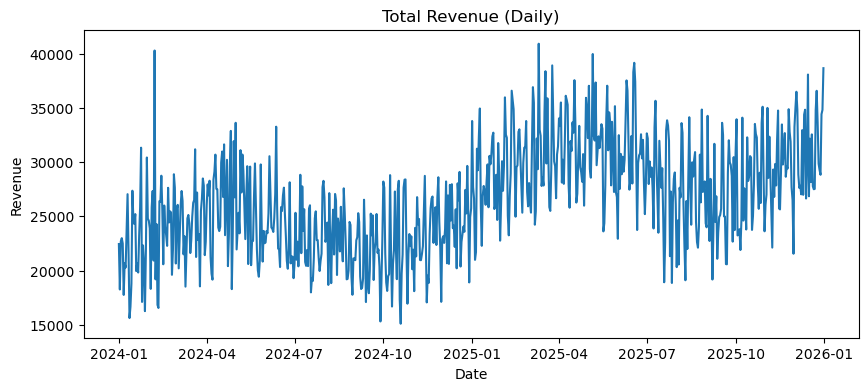

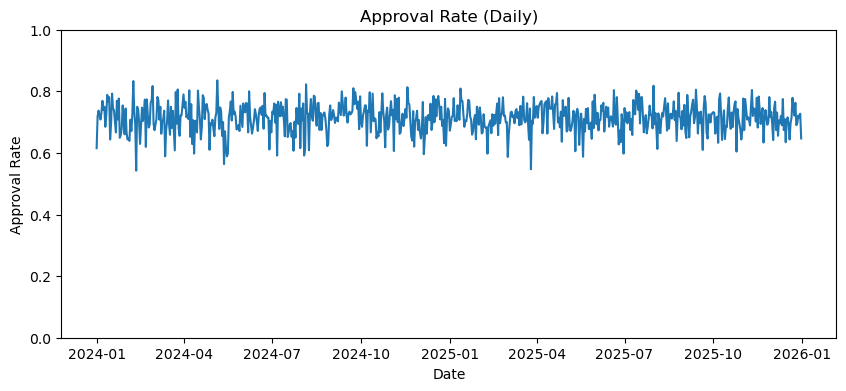

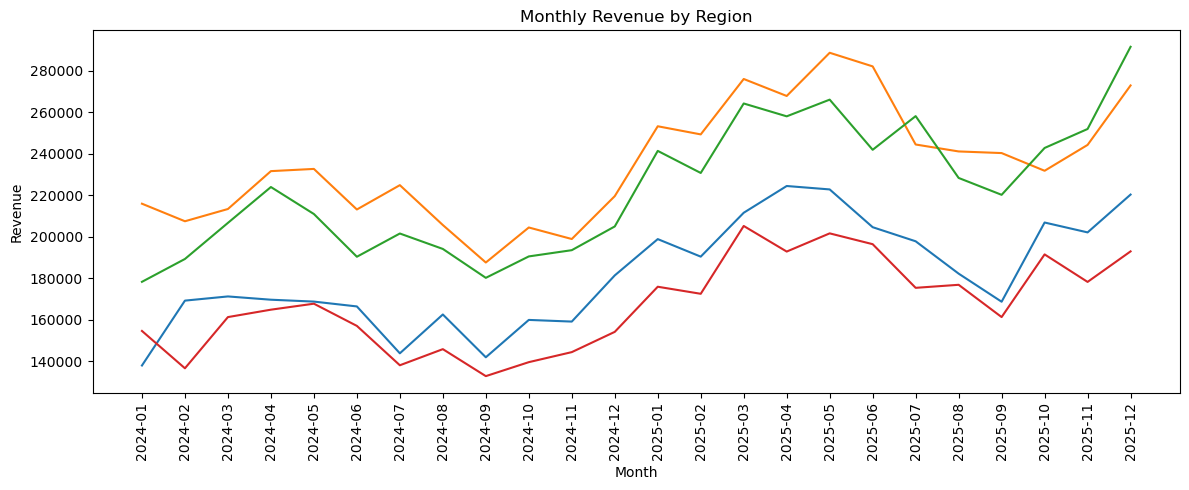

In [20]:

# Revenue trend
plt.figure(figsize=(10,4))
plt.plot(pd.to_datetime(daily["date"]), daily["total_revenue"])
plt.title("Total Revenue (Daily)")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.show()

# Approval rate trend
plt.figure(figsize=(10,4))
plt.plot(pd.to_datetime(daily["date"]), daily["approval_rate"])
plt.title("Approval Rate (Daily)")
plt.xlabel("Date")
plt.ylabel("Approval Rate")
plt.ylim(0, 1)
plt.show()

# Monthly revenue by region
monthly_region = df.groupby(["month", "region"]).agg(total_revenue=("revenue","sum")).reset_index()
pivot = monthly_region.pivot(index="month", columns="region", values="total_revenue").fillna(0)

plt.figure(figsize=(12,5))
plt.plot(pivot.index, pivot.values)
plt.title("Monthly Revenue by Region")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



## 7) Optional: To Create PowerBI Visualizations

Load Your Tables into Power BI 

You will load the output tables you created:

kpi_daily.csv

kpi_monthly_segmented.csv

leaderboard_monthly.csv

These are clean, BI-ready tables — perfect for Power BI.


This project focused on building a scalable analytics pipeline. I integrated customer and transaction data using Python, applied data quality checks to ensure reliability, and created KPI tables that feed Power BI dashboards. The goal was to eliminate manual reporting and provide stakeholders with trusted, up-to-date performance insights
